# Artificial Intelligence UE
## Assignment 4 - Propositional Logic & Decision Trees

<div class="alert alert-danger">
    <strong>Deadline:</strong> 09.12.2024, 12:00 (noon) 
</div>

In this assignment you are going to implement two rules from Propositional Logic and implement the ID3 algorithm.

The algorithm has been explained in the lecture (VO) and we gave you some additional information in the exercise (UE). Please refer to the lecture slides (VO) for the pseudo algorithms and the exercise slides (UE) for additional hints. 

<div class="alert alert-warning">

<p><strong>Automatic Grading:</strong></p>
<ul>
<li>Replace the placeholders <code># YOUR CODE HERE</code>, <code>raise NotImplementedError()</code> with your code.</li>
<li>Do not rename any of the already existing variables (this might lead to hidden tests failing / not working).</li>
<li>Do not delete or add cells.</li>
<li>We added a few cells that you can use for debugging your implementation (marked by <code># you can use this cell to test / debug your implementations - please empty it before submission (you can leave or remove the comment)</code>)</li>
<li>Hint: Once you've completed your implementation, if you're unsure whether any unintended changes were made to the original notebook, create a fresh copy of the provided notebook. Then, transfer your implementations to the new notebook before submitting.</li>
</ul>

<p><strong>Submission:</strong> Upload the notebook containing your implementation and answers, and change its name s.t. it contains "a4" and your student ID: </p>

    a4_<k/vk + 8 digits>.ipynb ; e.g., a4_k01234567.ipynb


<p><strong>Practical hints:</strong></p>
<ul>
<li>if you want a number smaller than all others, you may use <code>float('-Inf')</code></li>
<li>if you want a number larger than all others, you may use <code>float('Inf')</code></li>
</ul>
</div>

<div class="alert alert-info">

For the implementation of the information gain, we are going to use the `entropy` function provided by `scipy`. To install `scipy`:
<ul>
    <li>First, activate your environment: <code>conda activate ai2024</code></li>
    <li><code>pip install scipy==1.14.1</code></li>
</ul>

Note: The notebook has been tested with the original environment, and the environment after installing the additional libraries for A3 (i.e. it works with numpy=1.26.4 and numpy=2.1.0).
</div>

In [142]:
import numpy as np
from pig_lite.decision_tree.dt_node import DecisionTreeNodeBase
from pig_lite.decision_tree.dt_base import DecisionTree, DecisionTreeNode # dummy classes so that pickle works
from pig_lite.decision_tree.dt_base import entropy
from pig_lite.decision_tree.training_set import TrainingSet
from pig_lite.instance_generation.problem_factory import ProblemFactory

import pickle

## Propositional Logic (2 points)

Let us start by having a brief look at propositional logic. In the next cell, we provide you with an implementation of three functions for the logical operators $\land$ (AND), $\lor$ (OR), and $\neg$ (NOT). Feel free to experiment with these functions and understand what they are doing. If you need to refresh your memory on these operators and the next ones that you need to implement, you might want to check the Standard Inference Rules in the lecture slides.

In [143]:
def conjunction(alpha: bool, beta: bool) -> bool: # AND
    return alpha & beta

def disjunction(alpha: bool, beta: bool) -> bool: # OR
    return alpha | beta

def negation(alpha: bool) -> bool: # NOT
    return not alpha

The following cell contains some assertions to make sure that the functions defined above have not been changed and work as expected:

In [144]:
assert(conjunction(True, True) == True)

assert(negation(True) == False)
assert(negation(False) == True)

In [145]:
# you can use this cell to test / debug your implementations - please empty it before submission (you can leave or remove the comment)

Now you need to implement the next two operators, `implies(alpha, beta)` and `biconditional(alpha, beta)`. Where:

* `implies(alpha, beta)`: Represents the logical implication, $\alpha \implies \beta$
* `biconditional(alpha, beta)`: Represents the logical implication, $\alpha \Longleftrightarrow \beta$

Both functions take two boolean values (`alpha` and `beta`) as input and return the resulting boolean value. 

In your implementations, you can either use the functions defined above (`conjunction`, `disjunction`, `negation`) or the operators `&`, `|`, and `not`, whichever you prefer.

In [146]:
def implies(alpha: bool, beta: bool) -> bool:
    # YOUR CODE HERE
    # α → β is logically equivalent to ¬α ∨ β
    return disjunction(negation(alpha), beta)

In [147]:
# this cell contains hidden tests, please do not edit or delete it

In [148]:
def biconditional(alpha: bool, beta: bool) -> bool:
    # YOUR CODE HERE
    # α ↔ β is true when both are equal:
    # (α ∧ β) ∨ (¬α ∧ ¬β)
    return disjunction(
        conjunction(alpha, beta),
        conjunction(negation(alpha), negation(beta))
    )

In [149]:
# this cell contains hidden tests, please do not edit or delete it

## Decision Trees

In this section you are going to play around with the information gain of a dataset that you will create for this purpose, implement the ID3 algorithm for datasets with numeric features, and implement a method to predict values for new examples using your trained decision tree.

<div class="alert alert-info">
<p><strong>Tree Visualization</strong></p>
We provide you with different ways of visualizing the learned decision trees, which will be helpful for debugging your implementations.

You can visualize an instance of class `TrainingSet`: `training_set.visualize()`, which in this assignment will give you a 2D representation of the points in your dataset.  

You can also visualize the decision boundaries of a trained tree on top: `training_set.visualize(tree)`

Furthermore, you can print a trained decision tree: `tree.print()` (this might get messy for larger trees)

</div>

In the following we are loading a previously trained tree and the corresponding training set. This is the same example as shown in the exercise slides.

If you want to (it is not necessary for this exercise), you can also store trees:

```
with open("./demo/tree..pt", 'wb') as fh:
    pickle.dump(tree, fh)
```

and training sets:

```
json_str = training_set.to_json()
with open("./demo/data.json", 'w') as fh:
    fh.write(json_str)
```

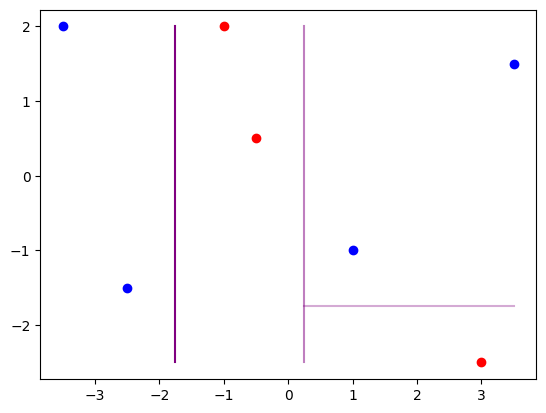

In [150]:
with open("./demo/tree.pt", 'rb') as fh:
    demo_tree = pickle.load(fh)

training_set = ProblemFactory().create_problem_from_json("./demo/data.json")
training_set.visualize(demo_tree)

In the following we show `tree.print()` for the example tree that was also used in the exercise slides.
- internal (non-leaf) nodes are represented as `(x0:-1.75)` (we split feature x0 at -1.75)
- leaf nodes are represented as `(    1   )` where the number represents the class label

In [151]:
demo_tree.print()

                                   (x0:-1.75)                                   
               (    1   )                               (x0:0.25)               
                                             (    0   )          (x1:-1.75)     
                                                            (    0   )(    1   )


### Information Gain (3 points)

To build a decision tree using the ID3 algorithm, you need to calculate the information gain. In the cell below, we provide you with a function that does this computation, using the entropy() function. entropy() is a wrapper for [the scipy.stats.entropy function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) for the case of binary classification. Feel free to check the documentation and see if you understand how these functions work. Note that in our data, we have two classes: 0 and 1.

In [152]:
def compute_information_gain(labels: np.array, x: np.array, split_point: float) -> float:
    """
    Calculate the information gain for a given feature and split point.

    Parameters
    ----------
    labels : np.array
        Binary class labels for the dataset.
    x : np.array
        Feature values corresponding to the labels.
    split_point : float
        The value at which to split the feature.

    Returns
    -------
    float
        The information gain resulting from the split.
    """

    # split labels according to split_point
    labels_left_branch = labels[x <= split_point]
    labels_right_branch = labels[x > split_point]

    # compute weight (what proportion of samples is going into the left and right branch)
    weight_left = len(labels_left_branch) / len(x)
    weight_right = len(labels_right_branch) / len(x)

    # compute entropy for all data, and the two created subsets
    e_data = entropy(labels)
    e_right = entropy(labels_right_branch)
    e_left = entropy(labels_left_branch)

    # compute and return information gain
    return e_data - (weight_left * e_left + weight_right * e_right)
    

Now let's create a small dataset and see what the information gain for this data looks like. The labels for our dataset will be stored in a numpy array of shape `(n_samples,)` and the features will be stored in a numpy array of shape `(n_samples, n_features)`. The cell below shows how these arrays can be initialized:

In [153]:
labels = np.array([0, 0, 0, 1, 1, 1])

X0 = np.array([ # samples (rows) x features (columns)
    [0.2, 1.5, 8.3, 4.0],
    [3.5, 2.3, 7.1, 2.4],
    [1.8, 6.4, 4.6, 4.5],
    [2.1, 3.9, 2.4, 3.0],
    [8.3, 4.0, 5.3, 3.0],
    [7.2, 2.1, 5.2, 2.0]
])

print(X0)


[[0.2 1.5 8.3 4. ]
 [3.5 2.3 7.1 2.4]
 [1.8 6.4 4.6 4.5]
 [2.1 3.9 2.4 3. ]
 [8.3 4.  5.3 3. ]
 [7.2 2.1 5.2 2. ]]


We can split the data along different features, and calculate the information gain for that split. The following code sets a threshold (`split_point=3.5` for each feature, also in the hidden tests for the information gain example) and computes the information gain.  

In [154]:
for i in range(X0.shape[1]):
    print(X0[:, i], compute_information_gain(labels, X0[:, i], split_point=3.5))

[0.2 3.5 1.8 2.1 8.3 7.2] 0.4591479170272448
[1.5 2.3 6.4 3.9 4.  2.1] 0.08170416594551055
[8.3 7.1 4.6 2.4 5.3 5.2] 0.19087450462110933
[4.  2.4 4.5 3.  3.  2. ] 0.4591479170272448


Now your task is to **create** `X0` in a way such that, 
* $\text{IG}(X0[:, 0]) = 0.0$
* $\text{IG}(X0[:, 0]) < \text{IG}(X0[:, 1]) < \text{IG}(X0[:, 2]) < \text{IG}(X0[:, 3])$
* $\text{IG}(X0[:, 3]) = 1.0$

Where $\text{IG}(X0[:, i])$ is the information gain for the ith column when split on the point `split_point=3.5`. First, think about what the data must look like to result in a low / high information gain with respect to the labels of the dataset and this particular split point.

All three conditions must hold for a single array `X0`. The datatype used, similar to the given example has to be a numpy array with the same dimensions. 

Do not modify `labels`, this will cause the hidden tests to fail.

In [155]:
X0 = None

# YOUR CODE HERE
X0 = np.array([
    [1.0, 2.0, 2.0, 1.0],
    [1.0, 2.0, 2.0, 2.0],
    [1.0, 4.0, 4.0, 3.0],
    [1.0, 2.0, 4.0, 4.0],
    [1.0, 4.0, 4.0, 5.0],
    [1.0, 4.0, 4.0, 6.0]
])

for i in range(X0.shape[1]):
    ig = compute_information_gain(labels, X0[:, i], split_point=3.5)
    print(f"Feature {i}: {X0[:, i]}, IG={ig}")

# feel free to use this cell to also print / look at your created dataset and the resulting information gains

Feature 0: [1. 1. 1. 1. 1. 1.], IG=0.0
Feature 1: [2. 2. 4. 2. 4. 4.], IG=0.08170416594551055
Feature 2: [2. 2. 4. 4. 4. 4.], IG=0.4591479170272448
Feature 3: [1. 2. 3. 4. 5. 6.], IG=1.0


In [156]:
# your modifications to X0 should have happened somewhere above this cell
# make sure that 'labels' and 'X0' still have the expected shapes
assert(labels.shape==(6,))
assert(X0.shape==(6, 4))

# this cell contains hidden tests, please do not edit or delete it

In [157]:
# this cell contains hidden tests, please do not edit or delete it

In [158]:
# this cell contains hidden tests, please do not edit or delete it

### ID3 Algorithm

In the next cell, you need to complete the implementation of several functions for a DecisionTreeNode following the instructions of the ID3 algorithm. Similar to the dataset you worked with above, the features of the data will be numeric and the labels will be binary. You need to complete three functions here:  

* `get_all_possible_split_points` returns a list of tuples, containing all the possible split points for each of the features in the data of the current node,  
* `get_optimal_split_point` can then use this function to find all the possible split points, and find the best split point based on information gain,  
* `split` performs the splitting of the ID3 algorithm recursivly, based on the optimal split point and split value. 

**Hints:**
* Each dataset, contains at least 2 samples and at least 2 features, i.e. `X` or `features` have a shape of at least (2, 2).
* We are considering a binary classification problem where labels are either `0` or `1`. However, not every dataset is guaranteed to contain samples from both classes.
* You can use `set(labels)` to get unique labels.

In [159]:
class DecisionTreeNode(DecisionTreeNodeBase):
    def __init__(self, features: np.ndarray, labels: np.ndarray):
        """
        Initialize a decision tree node with features and labels.

        Parameters
        ----------
        features : np.ndarray
            A 2D NumPy array where each row represents an instance and each column represents a feature.
            This array contains the feature values for the data points at the current node.
            Example:
                np.array([
                    [1.2, 3.4, 5.6],  # Instance 1 with 3 features
                    [7.8, 9.0, 2.1],  # Instance 2 with 3 features
                    [4.5, 6.7, 8.9]   # Instance 3 with 3 features
                ])
        labels : np.ndarray
            A 1D NumPy array of integers, where each element corresponds to the class label of an instance.
            This array contains the labels of the data points at the current node.
            Example:
                np.array([0, 1, 0])  # Instance 1 belongs to class 0, Instance 2 belongs to class 1, and so on.

        """

        super().__init__()
        self.features = features
        self.labels = labels
        self.left_child = None
        self.right_child = None

    def get_all_possible_split_points(self) -> list[tuple]:
        """
        Identify all possible split points for features in the dataset.

        This method generates potential split points for each feature in the dataset based on changes in the labels. 
        A split point is defined as the midpoint between two successive feature values where the labels and features differ.

        Returns
        -------
        list[tuple]
            A list of tuples `(f_idx, split_at)`, where `f_idx` is the feature index and `split_at` is the value 
            at which the split occurs.
        Notes for Students
        ------------------
        - The input dataset is stored in `self.features` (a 2D NumPy array) and `self.labels` (a 1D NumPy array).
        - Make sure to use features and labels that has already been sorted for you
        - You should:
            1. Iterate over all samples
            2. Check whether it makes sense to split at this point, if yes: store the split point
        """

        nr_samples, nr_features = self.features.shape
        split_points = []

        for f_idx in range(nr_features):
            # we use argsort so we can used the indeces to sort the labels accordingly
            idx_sort = self.features[:, f_idx].argsort()
            features = self.features[idx_sort, :] # <- use this instead of self.features
            labels = self.labels[idx_sort] # <- use this instead of self.labels
                    
            # YOUR CODE HERE
            for i in range(nr_samples - 1):
            # 当两个相邻样本的标签不同且特征值也不同才有意义分割
                if labels[i] != labels[i + 1] and features[i, f_idx] != features[i + 1, f_idx]:
                # 分割点为两样本特征值的中点
                    split_at = (features[i, f_idx] + features[i + 1, f_idx]) / 2.0
                    split_points.append((f_idx, split_at))
            

        return split_points

    def get_optimal_split_point(self) -> tuple[int, float]:
        """
        Find the optimal split point for the dataset.

        This method identifies the feature and value that provide the highest information gain when splitting the data. 
        It uses the method `self.get_all_possible_split_points()` to generate potential splits and evaluates each split 
        using `compute_information_gain`.

        Returns
        -------
        tuple
            A tuple `(split_feature, split_point)`, where:
            - `split_feature` is the index of the feature to split on.
            - `split_point` is the value of the feature at which to split.

        Notes for Students
        ------------------
        - Step 1: Use `self.get_all_possible_split_points()` to retrieve a list of potential split points. 
                Each split point is a tuple `(f_idx, split_at)`.
        - Step 2: Iterate over the list of possible split points:
            - For each split point, calculate the information gain using the `compute_information_gain` function.
            - Keep track of the split point that gives the highest information gain.
        - Step 3: Return the feature index and value of the split with the best information gain.
        """

        split_feature, split_point = None, None

        # YOUR CODE HERE
    
        # 获取所有可用分割点
        candidate_splits = self.get_all_possible_split_points()

        if len(candidate_splits) == 0:
            # 无可分割点（意味着全为同类，或者数据无区分度）
            return None, None

        best_ig = -1
        best_split = (None, None)

        for f_idx, split_at in candidate_splits:
            ig = compute_information_gain(self.labels, self.features[:, f_idx], split_at)
            if ig > best_ig:
                best_ig = ig
                best_split = (f_idx, split_at)

        return best_split

    def split(self) -> DecisionTreeNode:
        """
            Split the current node using the ID3 algorithm based on the lecture slides "The ID3 Algorithm"

            Notes for Students
            --------
            The following steps correspond to the steps on the lecture (VO) slide "ID3: The Full Algorithm"
            1. If all examples X in the current node belong to the same class, make current node a leaf (i.e. label with class (integer value), and EXIT)
            2. Our implementation differs here, each feature can be split several times (see exercise slides)
            3. + 4. Use get_optimal_split_point() to determine the best feature to split on.
            5. + 6. Create a branch + successor node N_i for each value of the selected feature containing a subset of X 
                - Instances where the feature value is less than or equal (<=) to the split point go to the left child (assign to self.left_child).
                - Instances where the feature value is greater (>) than the split point go to the right child (assign to self.right_child).
            7. For each subnode (self.left_child, self.right_child) call split
            
            Returns
            -------
            self : DecisionTreeNode
                The current node after the split, which may have new left and right child nodes.

        """

        # YOUR CODE HERE
        # Step 1: 如果该节点的所有样本都是同一类，则直接成为叶子节点
        unique_labels = set(self.labels)
        if len(unique_labels) == 1:
            # 所有样本同一标签
            self.label = unique_labels.pop()
            return self

        # Step 3 + 4: 寻找最优分割特征及分割点
        split_feature, split_point = self.get_optimal_split_point()
        if split_feature is None:
            # 无法找到合理分割点（可能特征无区分度）
            # 此时将该节点标记为叶节点，标签使用出现最多的类
            counts = np.bincount(self.labels)
            self.label = np.argmax(counts)
            return self

        self.split_feature = split_feature
        self.split_point = split_point

        # Step 5 + 6: 按分割点划分数据集
        left_mask = self.features[:, split_feature] <= split_point
        right_mask = self.features[:, split_feature] > split_point

        self.left_child = DecisionTreeNode(self.features[left_mask, :], self.labels[left_mask])
        self.right_child = DecisionTreeNode(self.features[right_mask, :], self.labels[right_mask])

        # Step 7: 递归对左右子节点进行分裂
        self.left_child.split()
        self.right_child.split()
        
        return self


In [160]:
# you can use this cell to test / debug your implementations - please empty it before submission (you can leave or remove the comment)

#### Basic Tests

These tests check some basic functionality and should help you debug your algorithm. They are not graded this time but should give you an idea what the hidden tests could look like for (possibly) more complicated datasets.

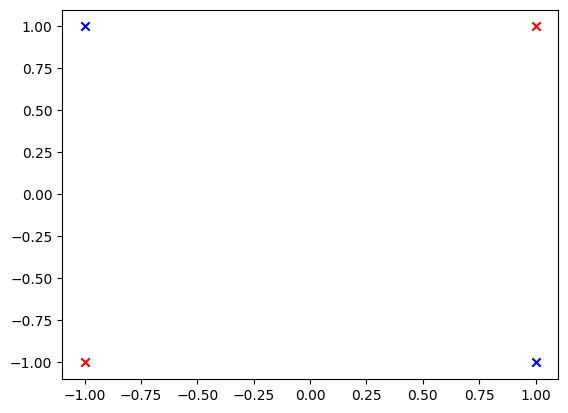

In [161]:
X_basic_test = np.array([[1, 1],
                         [-1, -1],
                         [-1, 1],
                         [1, -1]])
y_basic_test = np.array([0, 0, 1, 1])

# this is only a test node and not a tree (this means you can not visualize it on top of the dataset)
dt_basic_test_node = DecisionTreeNode(features=X_basic_test, labels=y_basic_test)

TrainingSet(X_basic_test, y_basic_test).visualize()

In [162]:
n_apsp = len(dt_basic_test_node.get_all_possible_split_points())
assert(n_apsp == 2), f'Expected 2 possible splitting points, but found {n_apsp}. Check your logic for determining split points.'

In [163]:
# optimal split points
assert(dt_basic_test_node.get_optimal_split_point()[0] == 0), 'something is wrong with your implementation of the method get_optimal_split_point()'

In [164]:
# the split method
assert(isinstance(dt_basic_test_node.split(), DecisionTreeNode)), 'your implemenation of split() should return a DecisionTreeNode'

### DecisionTree - predict()

This section now contains the class `DecisionTree` which contains the function to fit a tree (already implemented) and the function to predict labels for a new dataset (to be implemented by you).

The predict(X) function should take in numpy.array `X` containing feature values for which we want to compute predictions. The predictions should be returned as a Python list.

Hints:
* You can use `for x in X` to loop over the data. You can also do it differently as long as the output is correct.
* Ensure that you properly handle cases where a node is a leaf (i.e., `split_point` is `None`).
* The predicted label can be converted to a standard Python type using `.item()` (not required, but makes the output look cleaner).

In [165]:
class DecisionTree():
    def __init__(self) -> None:
        self.root = None

    def __str__(self):
        return str(self.root)

    def fit(self, training_set):
        self.root = DecisionTreeNode(training_set.X, training_set.y)
        self.root.split()
        return self
    
    def get_height(self, node):
        if node is None:
            return 0
        return max(self.get_height(node.left_child), self.get_height(node.right_child)) + 1
    
    def print(self):
        if self.root is not None:
            height = self.get_height(self.root)
            self.root.print_tree(height)

    def predict(self, X: np.ndarray) -> list:
        """
        Predict the labels for a set of input samples using the decision tree.

        This method traverses the decision tree for each input sample in `X`, starting from the root node. 
        It follows the splits based on the features and split points until it reaches a leaf node, where the 
        predicted label is stored.

        Parameters
        ----------
        X : np.ndarray
            A 2D NumPy array where each row represents a sample and each column represents a feature.

        Returns
        -------
        list
            A list of predicted labels for each sample in `X`.

        Notes for Students
        ------------------
        - The prediction starts at the root of the decision tree (`self.root`) and proceeds down the tree until 
        a leaf node is reached.
        - At each node:
            - Compare the sample's feature value at `split_feature` to the `split_point`.
            - Traverse to the `left_child` if the feature value is less than or equal to the `split_point`.
            - Traverse to the `right_child` if the feature value is greater than the `split_point`.
        - Once a leaf node is reached, the `label` of that node is appended to the predictions list.
        """
        labels = []
        # YOUR CODE HERE
        for x in X:
            # 从根节点开始
            current_node = self.root
            # 遍历树直到到达叶子节点
            while current_node.label is None:
                # 根据节点的分割特征和分割点决定走向
                if x[current_node.split_feature] <= current_node.split_point:
                    current_node = current_node.left_child
                else:
                    current_node = current_node.right_child
            # current_node为叶节点，取其label作为预测
            labels.append(current_node.label.item() if hasattr(current_node.label, 'item') else current_node.label)
            
        return labels
    

In [166]:
# you can use this cell to test / debug your implementations - please empty it before submission (you can leave or remove the comment)

The following cell contains a very basic test that should help you debug your implementations, and is also not graded.

In [167]:
id3_tree = DecisionTree()

# a new tree is trained on the previously defined training set and used to predict two new examples
id3_tree.fit(training_set)

# feel free to play around with the samples
X1 = np.array([[-3, 0],
               [-1, -2]])

y1 = id3_tree.predict(X=X1)

assert(y1[0] == 1), 'predict(X1[0]) expected to be 1.0'
assert(y1[1] == 0), 'predict(X1[1]) expected to be 0.0'


## Additional tests

The following contains additional tests for the functions you implemented. These will be graded.

<div class="alert alert-danger">
    <strong>Attention!</strong> Do not change anything below this point!
</div>

### get_all_possible_split_points() (2 points)

In [168]:
# this cell contains hidden tests, please do not edit or delete it


In [169]:
# this cell contains hidden tests, please do not edit or delete it

### get_optimal_split_point() (1 point)

In [170]:
# this cell contains hidden tests, please do not edit or delete it


### split() (4 points)

In [171]:
# this cell contains hidden tests, please do not edit or delete it

In [172]:
# this cell contains hidden tests, please do not edit or delete it

In [173]:
# this cell contains hidden tests, please do not edit or delete it

In [174]:
# this cell contains hidden tests, please do not edit or delete it

### predict() (3 points)

For these tests we are going to use a previously trained tree using our reference implementation. This means even if your ID3 implementation does not work correctly, you can get all the points for these tests.

In [175]:
# this cell contains hidden tests, please do not edit or delete it



In [176]:
# this cell contains hidden tests, please do not edit or delete it

In [177]:
# this cell contains hidden tests, please do not edit or delete it